# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

All'interno della funzione initialize_properties() in system.cpp ho aggiunto il calcolo delle correzioni di coda per l'energia potenziale e la pressione implementate in questo modo (ciclando sulle coppie di particelle):

```cpp
for (int i=0; i<_npart-1; i++){
    vec distance;
    distance.resize(_ndim);
    double dr;
    for (int j=i+1; j<_npart; j++){
        distance(0) = this->pbc( _particle(i).getposition(0,true) - _particle(j).getposition(0,true), 0);
        distance(1) = this->pbc( _particle(i).getposition(1,true) - _particle(j).getposition(1,true), 1);
        distance(2) = this->pbc( _particle(i).getposition(2,true) - _particle(j).getposition(2,true), 2);
        dr = sqrt( dot(distance,distance) );
        _vtail = 8*M_PI*_rho*(1.0/(9*pow(dr,9)) - 1.0/(3*pow(dr,3))); // POTENTIAL ENERGY
        _ptail = 32*M_PI*_rho*(1.0/(9*pow(dr,9)) - 1.0/(6*pow(dr,3))); // PRESSURE
    }
}
```

### Exercise 07.2

Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

Per prima cosa ho introdotto una variabile agguiuntiva di tipo string nel mio file di input che poteva assumere due valori: 'AUTOCORR' o 'FINAL'. In questo modo ho potuto inidirizzare in due file di output diversi le misure istantanee dell'energia potenziale per il calcolo dell'autocorrelazione dalle misure successive a blocchi una volta deciso la dimensione di questi ultimi. Sono stati utilizzati i seguenti valori di delta per ottenere un'accettanza di circa 50% in tutte e tre le simulazioni:

1. $\delta_{SOLID}$ = 0.05
2. $\delta_{LIQUID}$ = 0.1
3. $\delta_{GAS}$ = 5.0

Il seguente grafico riporta l'autocorrelazione dei dati istantanei di energia potenziale nei tre casi coi rispettivi fit esponenziali.

tau_solido:  10.119844872332603 tau_liquido:  10.950940979648262 tau_gas:  2.2107881033422654


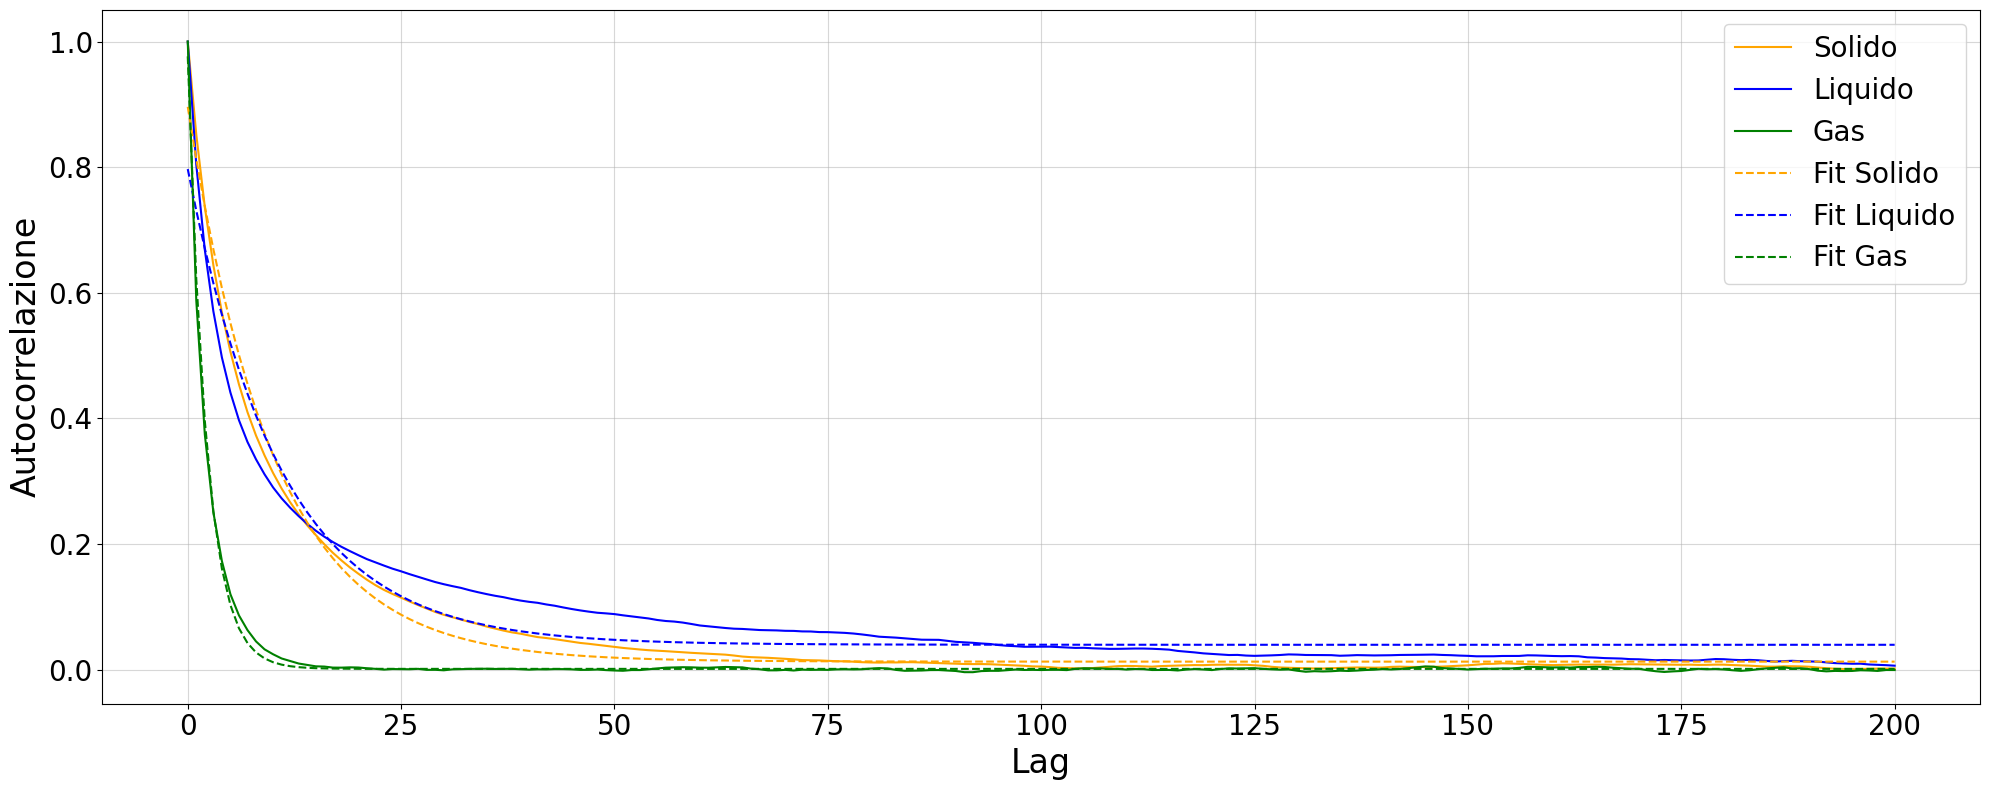

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

df_solid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/AUTOCORR/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])
data_solid = df_solid['ACTUAL_PE']
df_liquid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/AUTOCORR/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])
data_liquid = df_liquid['ACTUAL_PE']
df_gas = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/AUTOCORR/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])
data_gas = df_gas['ACTUAL_PE']

autocorr_solid = sm.tsa.acf(data_solid, nlags=200)
autocorr_liquid = sm.tsa.acf(data_liquid, nlags=200)
autocorr_gas = sm.tsa.acf(data_gas, nlags=200)

x = np.linspace(0, 200, 201)
popt_solid, pcov_solid = curve_fit(exponential_func, x, autocorr_solid)
a_fit_solid, b_fit_solid, c_fit_solid = popt_solid
popt_liquid, pcov_liquid = curve_fit(exponential_func, x, autocorr_liquid)
a_fit_liquid, b_fit_liquid, c_fit_liquid = popt_liquid
popt_gas, pcov_gas = curve_fit(exponential_func, x, autocorr_gas)
a_fit_gas, b_fit_gas, c_fit_gas = popt_gas

print("tau_solido: ", (1/b_fit_solid), "tau_liquido: ", (1/b_fit_liquid), "tau_gas: ", (1/b_fit_gas))

plt.figure(figsize=(20, 8))
plt.plot(autocorr_solid, label='Solido', color='orange')
plt.plot(autocorr_liquid, label='Liquido', color='blue')
plt.plot(autocorr_gas, label='Gas', color='green')
plt.plot(x, exponential_func(x, a_fit_solid, b_fit_solid, c_fit_solid), label='Fit Solido', color='orange', linestyle='--')
plt.plot(x, exponential_func(x, a_fit_liquid, b_fit_liquid, c_fit_liquid), label='Fit Liquido', color='blue', linestyle='--')
plt.plot(x, exponential_func(x, a_fit_gas, b_fit_gas, c_fit_gas), label='Fit Gas', color='green', linestyle='--')
plt.xlabel('Lag', fontsize=24)
plt.ylabel('Autocorrelazione', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, alpha=0.5)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In seguito è riportato l'errore statistico in funzione della lunghezza dei blocchi.

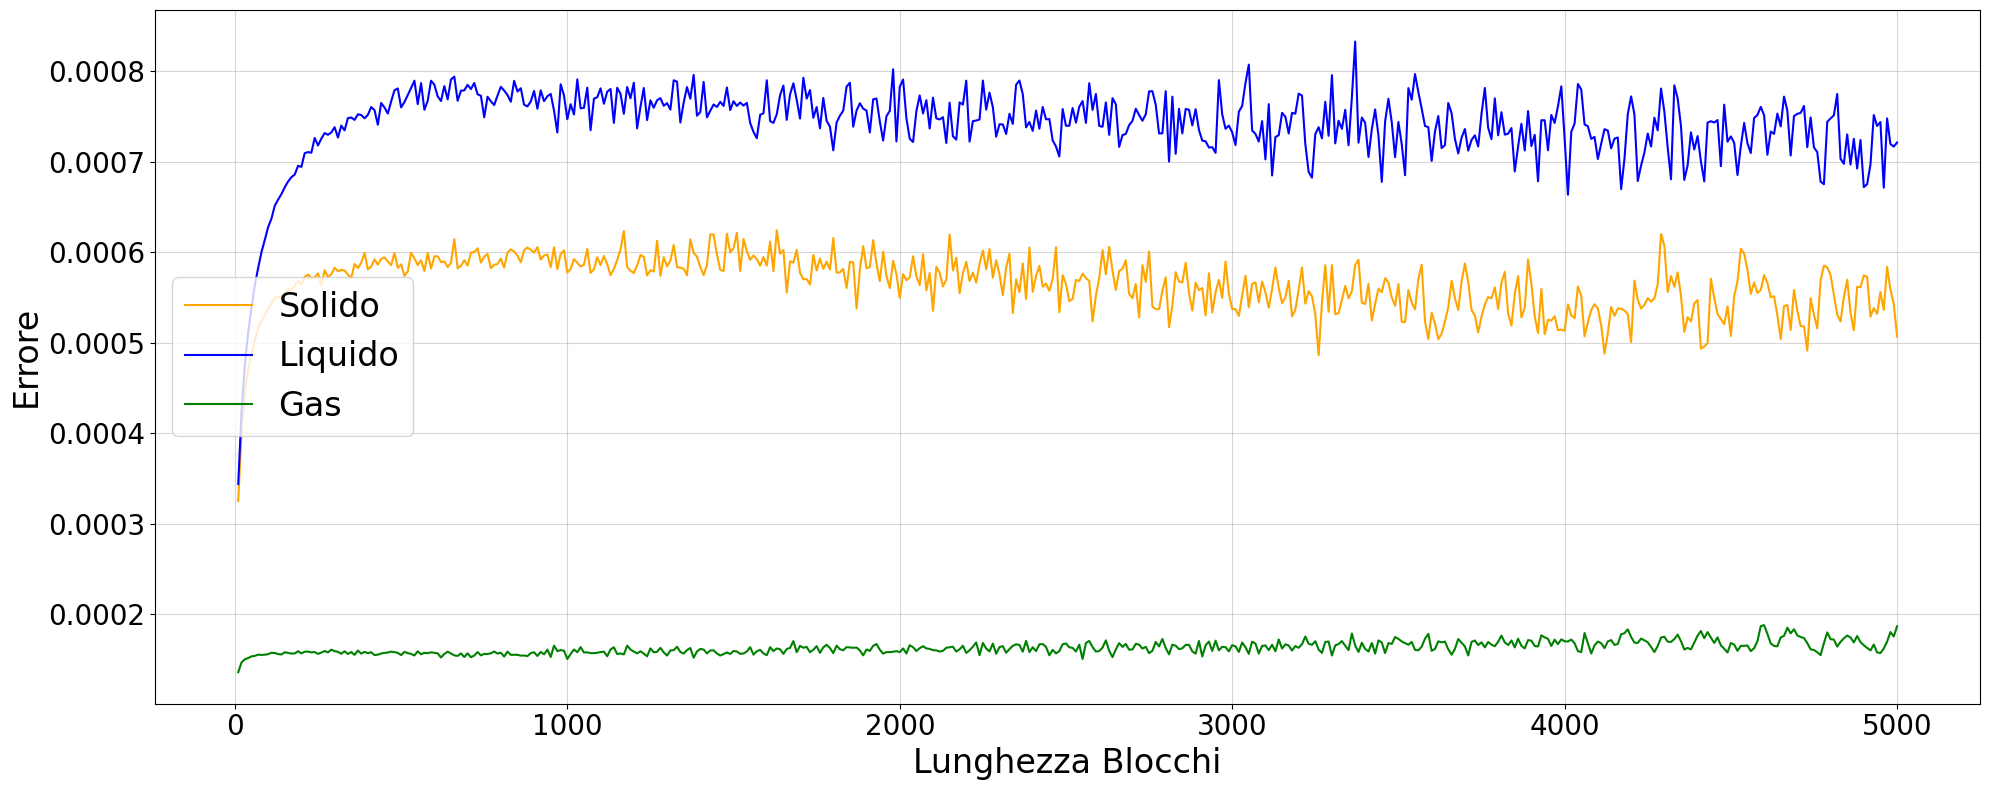

In [29]:
def calculate_error(average, averageSquared, n):
	if n == 0:
		return 0	
	return np.sqrt((averageSquared - average ** 2) / n)

def block_average (data, blocks, blockSize):
	progressiveAverage = 0
	progressiveAverageSquared = 0
	progressiveError = 0

	for blockIndex in range(blocks):
		blockSum = 0

		for dataIndex in range(blockSize):
			blockSum += data[dataIndex + blockIndex * blockSize]

		blockMean = blockSum / blockSize

		progressiveAverage = (progressiveAverage * blockIndex + blockMean) / (blockIndex + 1)
		progressiveAverageSquared = (progressiveAverageSquared * blockIndex + blockMean**2) / (blockIndex + 1)
		progressiveError = calculate_error(progressiveAverage, progressiveAverageSquared, blockIndex)

	return progressiveError

x = []
error_solid = []
error_liquid = []
error_gas = []

for i in range(10, 5001, 10) :
    n = 500000 // i
    x.append(i)
    error_solid.append(block_average(data_solid, n, i))
    error_liquid.append(block_average(data_liquid, n, i))
    error_gas.append(block_average(data_gas, n, i))

plt.figure(figsize=(20, 8))
plt.plot(x, error_solid, label='Solido', color='orange')
plt.plot(x, error_liquid, label='Liquido', color='blue')
plt.plot(x, error_gas, label='Gas', color='green')
plt.xlabel('Lunghezza Blocchi', fontsize=24)
plt.ylabel('Errore', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, alpha=0.5)
plt.legend(fontsize=24)
plt.tight_layout()
plt.show()

Ho deciso quindi di utilizzare blocchi di 2000 step Monte Carlo dove l'incertezza è ormai saturata ad un valore costante per non sottostimarla con blocchi di lunghezza inferiore e senza utilizzare blocchi inutilmente grandi con la stessa incertezza statistica.

### Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

Ho incluso nel mio codice il calcolo della funzione $g(r)$ aggiungendo nella funzione measure() un contatore che 2 per ogni bin, corrispondente a un certo intervallo di valori del raggio tra $r$ e $r+\delta r$, nel caso in cui trovasse una particella all'interno di quel volume. La funzione di distribuzione radiale descrive la probabilità di trovare una particella a distanza $r$ da una particella di riferimento. La $g(r)$ si calcola come segue:

<div style="text-align: center;">

### $g(r) =\frac{1}{\rho N\Delta V(r)} \left\langle \sum_{i=1}^N \sum_{j=1,\neq i}^N \delta(r-|\vec r_i-\vec r_j |) \right\rangle$

</div>
 
dove $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$ è il volume della corona sferica in cui viene cercata la particella.

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ...  and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

I seguenti grafici riportano i valori di $U/N$, $P$ e $g(r)$ lungo il corso della simulazione per le tre condizioni di stato. I valori di $g(r)$ sono stati normalizzati dividendo per il volume della corona sferica all'interno del quale si trovano le particelle.

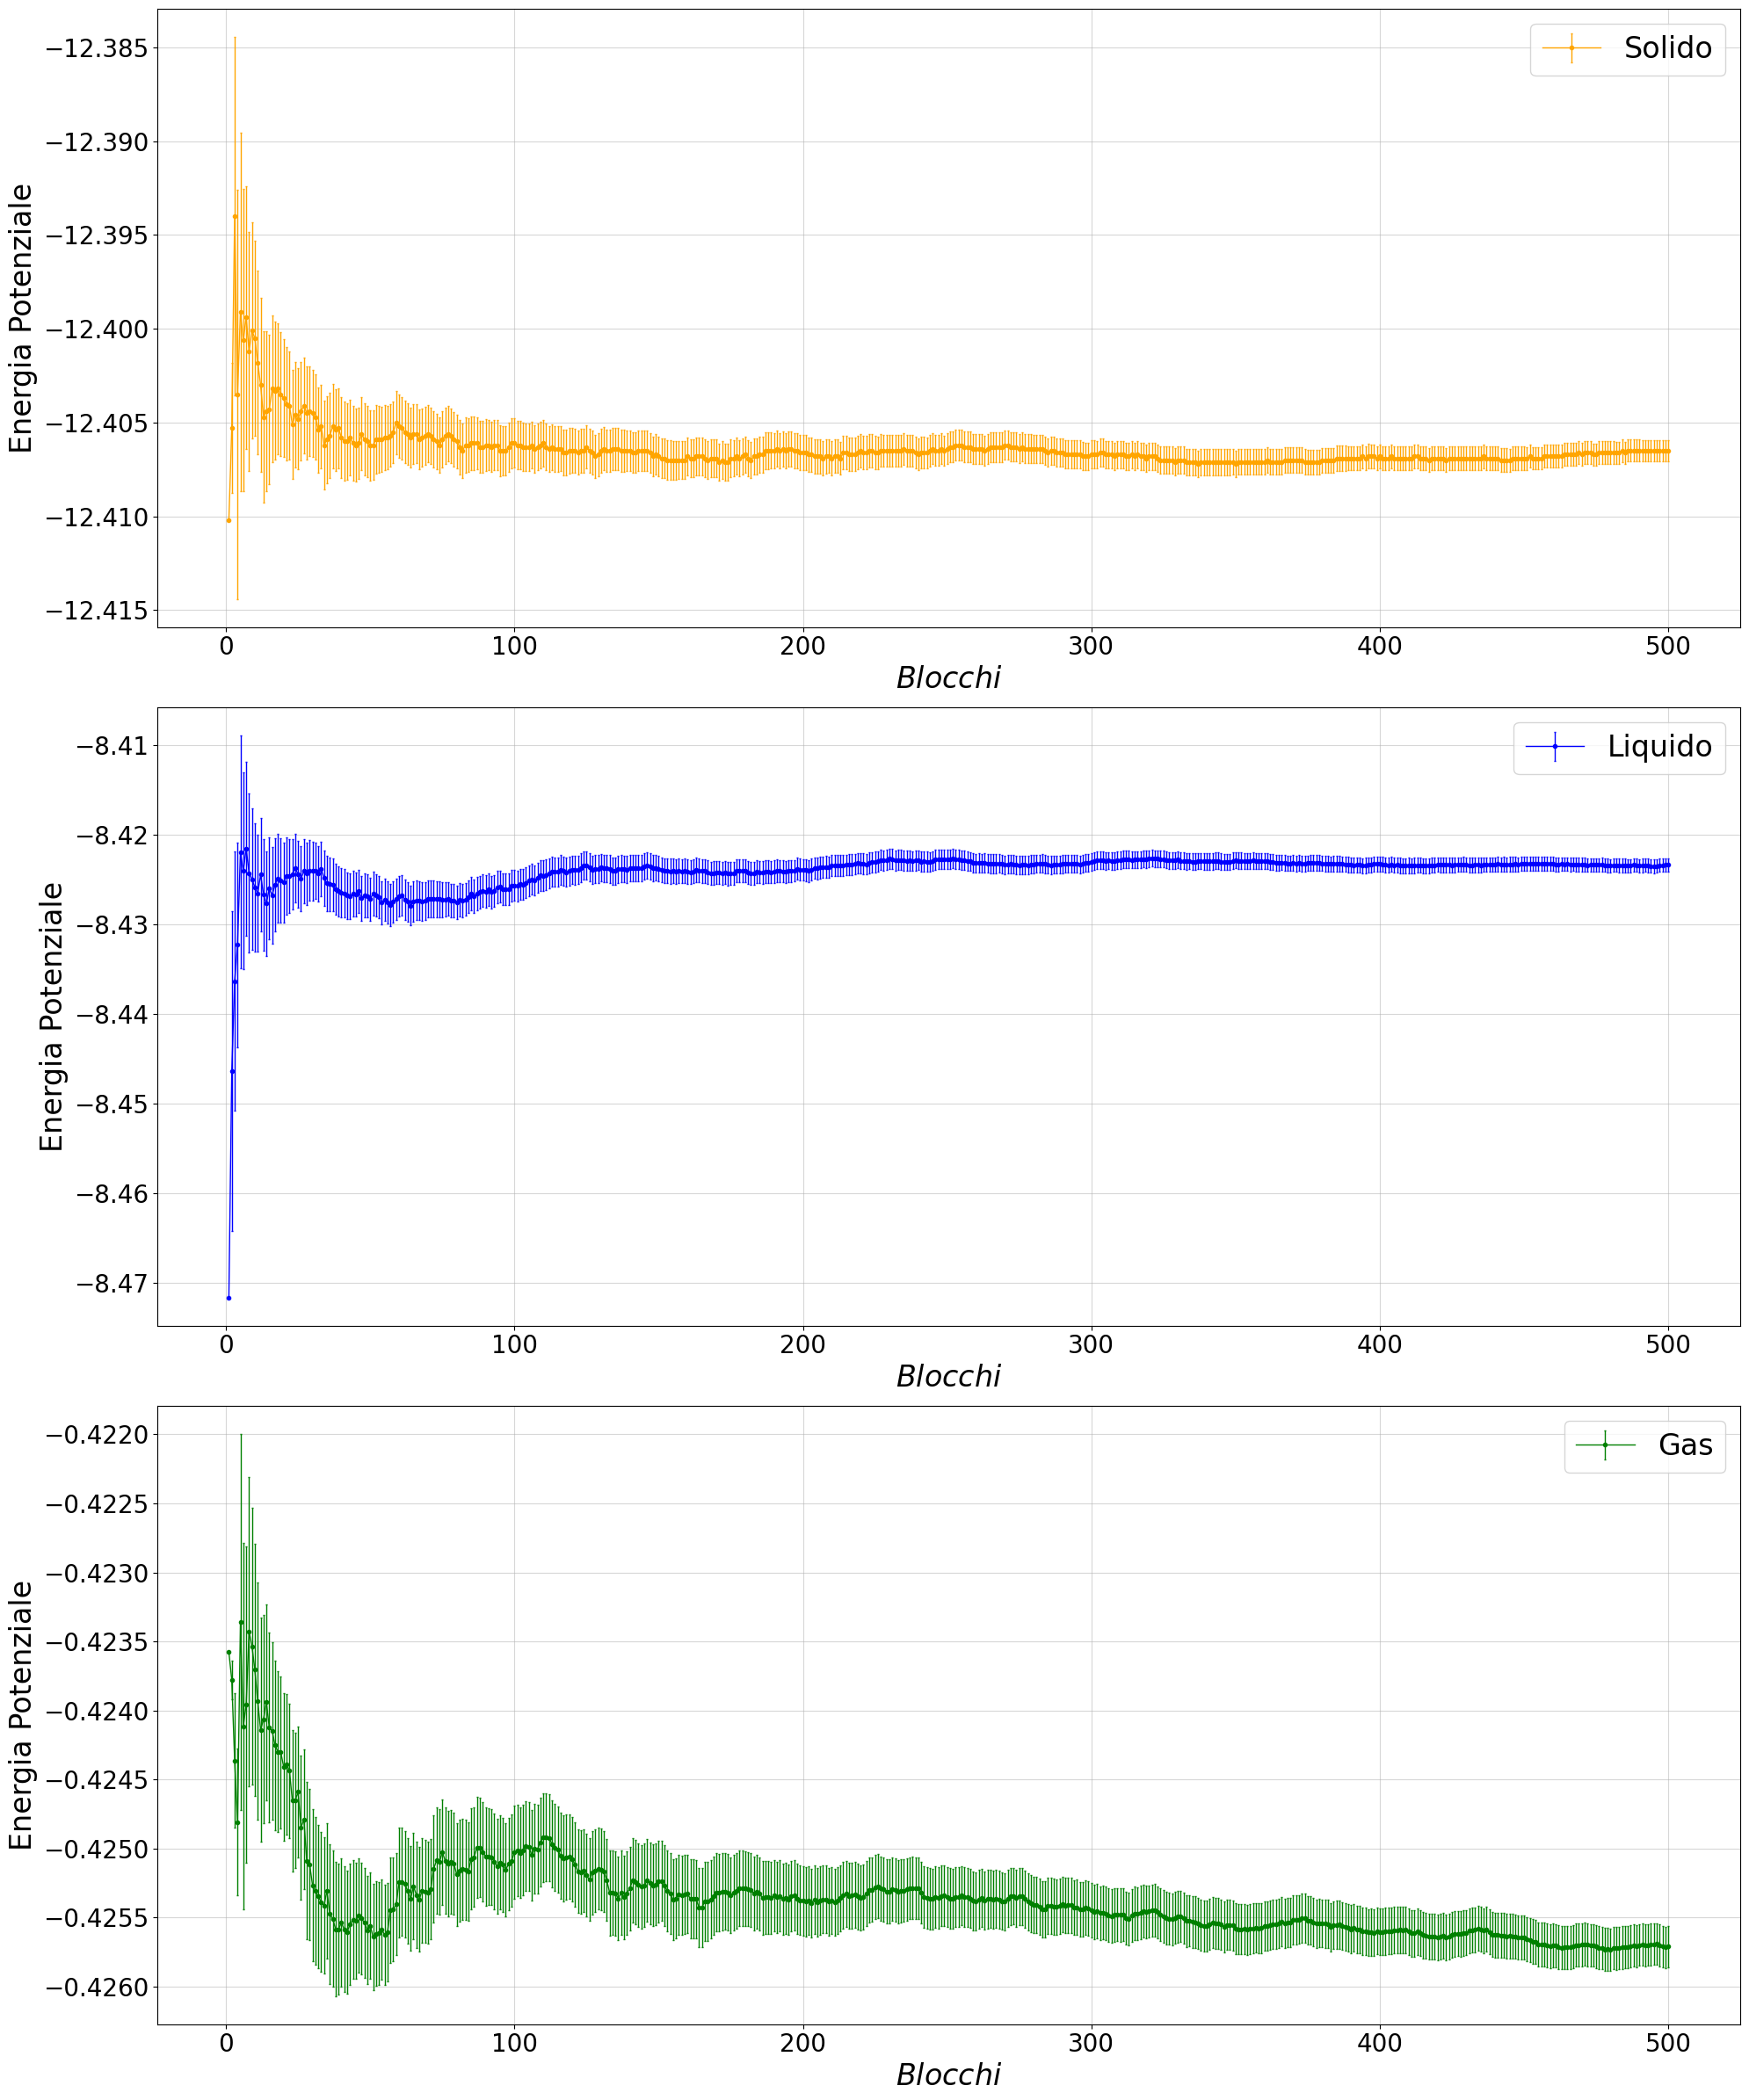

In [16]:
df_solid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/FINAL/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])
df_liquid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/FINAL/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])
df_gas = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/FINAL/potential_energy.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_PE', 'PE_AVE', 'ERROR'])

x = np.arange(1, 501, 1)

def plotting(name, abbreviation, phase, color, number, df):
    plt.subplot(3, 1, number)
    plt.errorbar(x, df[abbreviation + '_AVE'], yerr=df['ERROR'], fmt='o-', label=phase, color=color, markersize=3, linewidth=1, capsize=0.8)
    plt.xlabel('$Blocchi$', fontsize=24)
    plt.ylabel(name, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=24)

plt.figure(figsize=(20,24))

plotting('Energia Potenziale', 'PE', 'Solido', 'orange', 1, df_solid)
plotting('Energia Potenziale', 'PE', 'Liquido', 'blue', 2, df_liquid)
plotting('Energia Potenziale', 'PE', 'Gas', 'green', 3, df_gas)

plt.tight_layout()
plt.show()

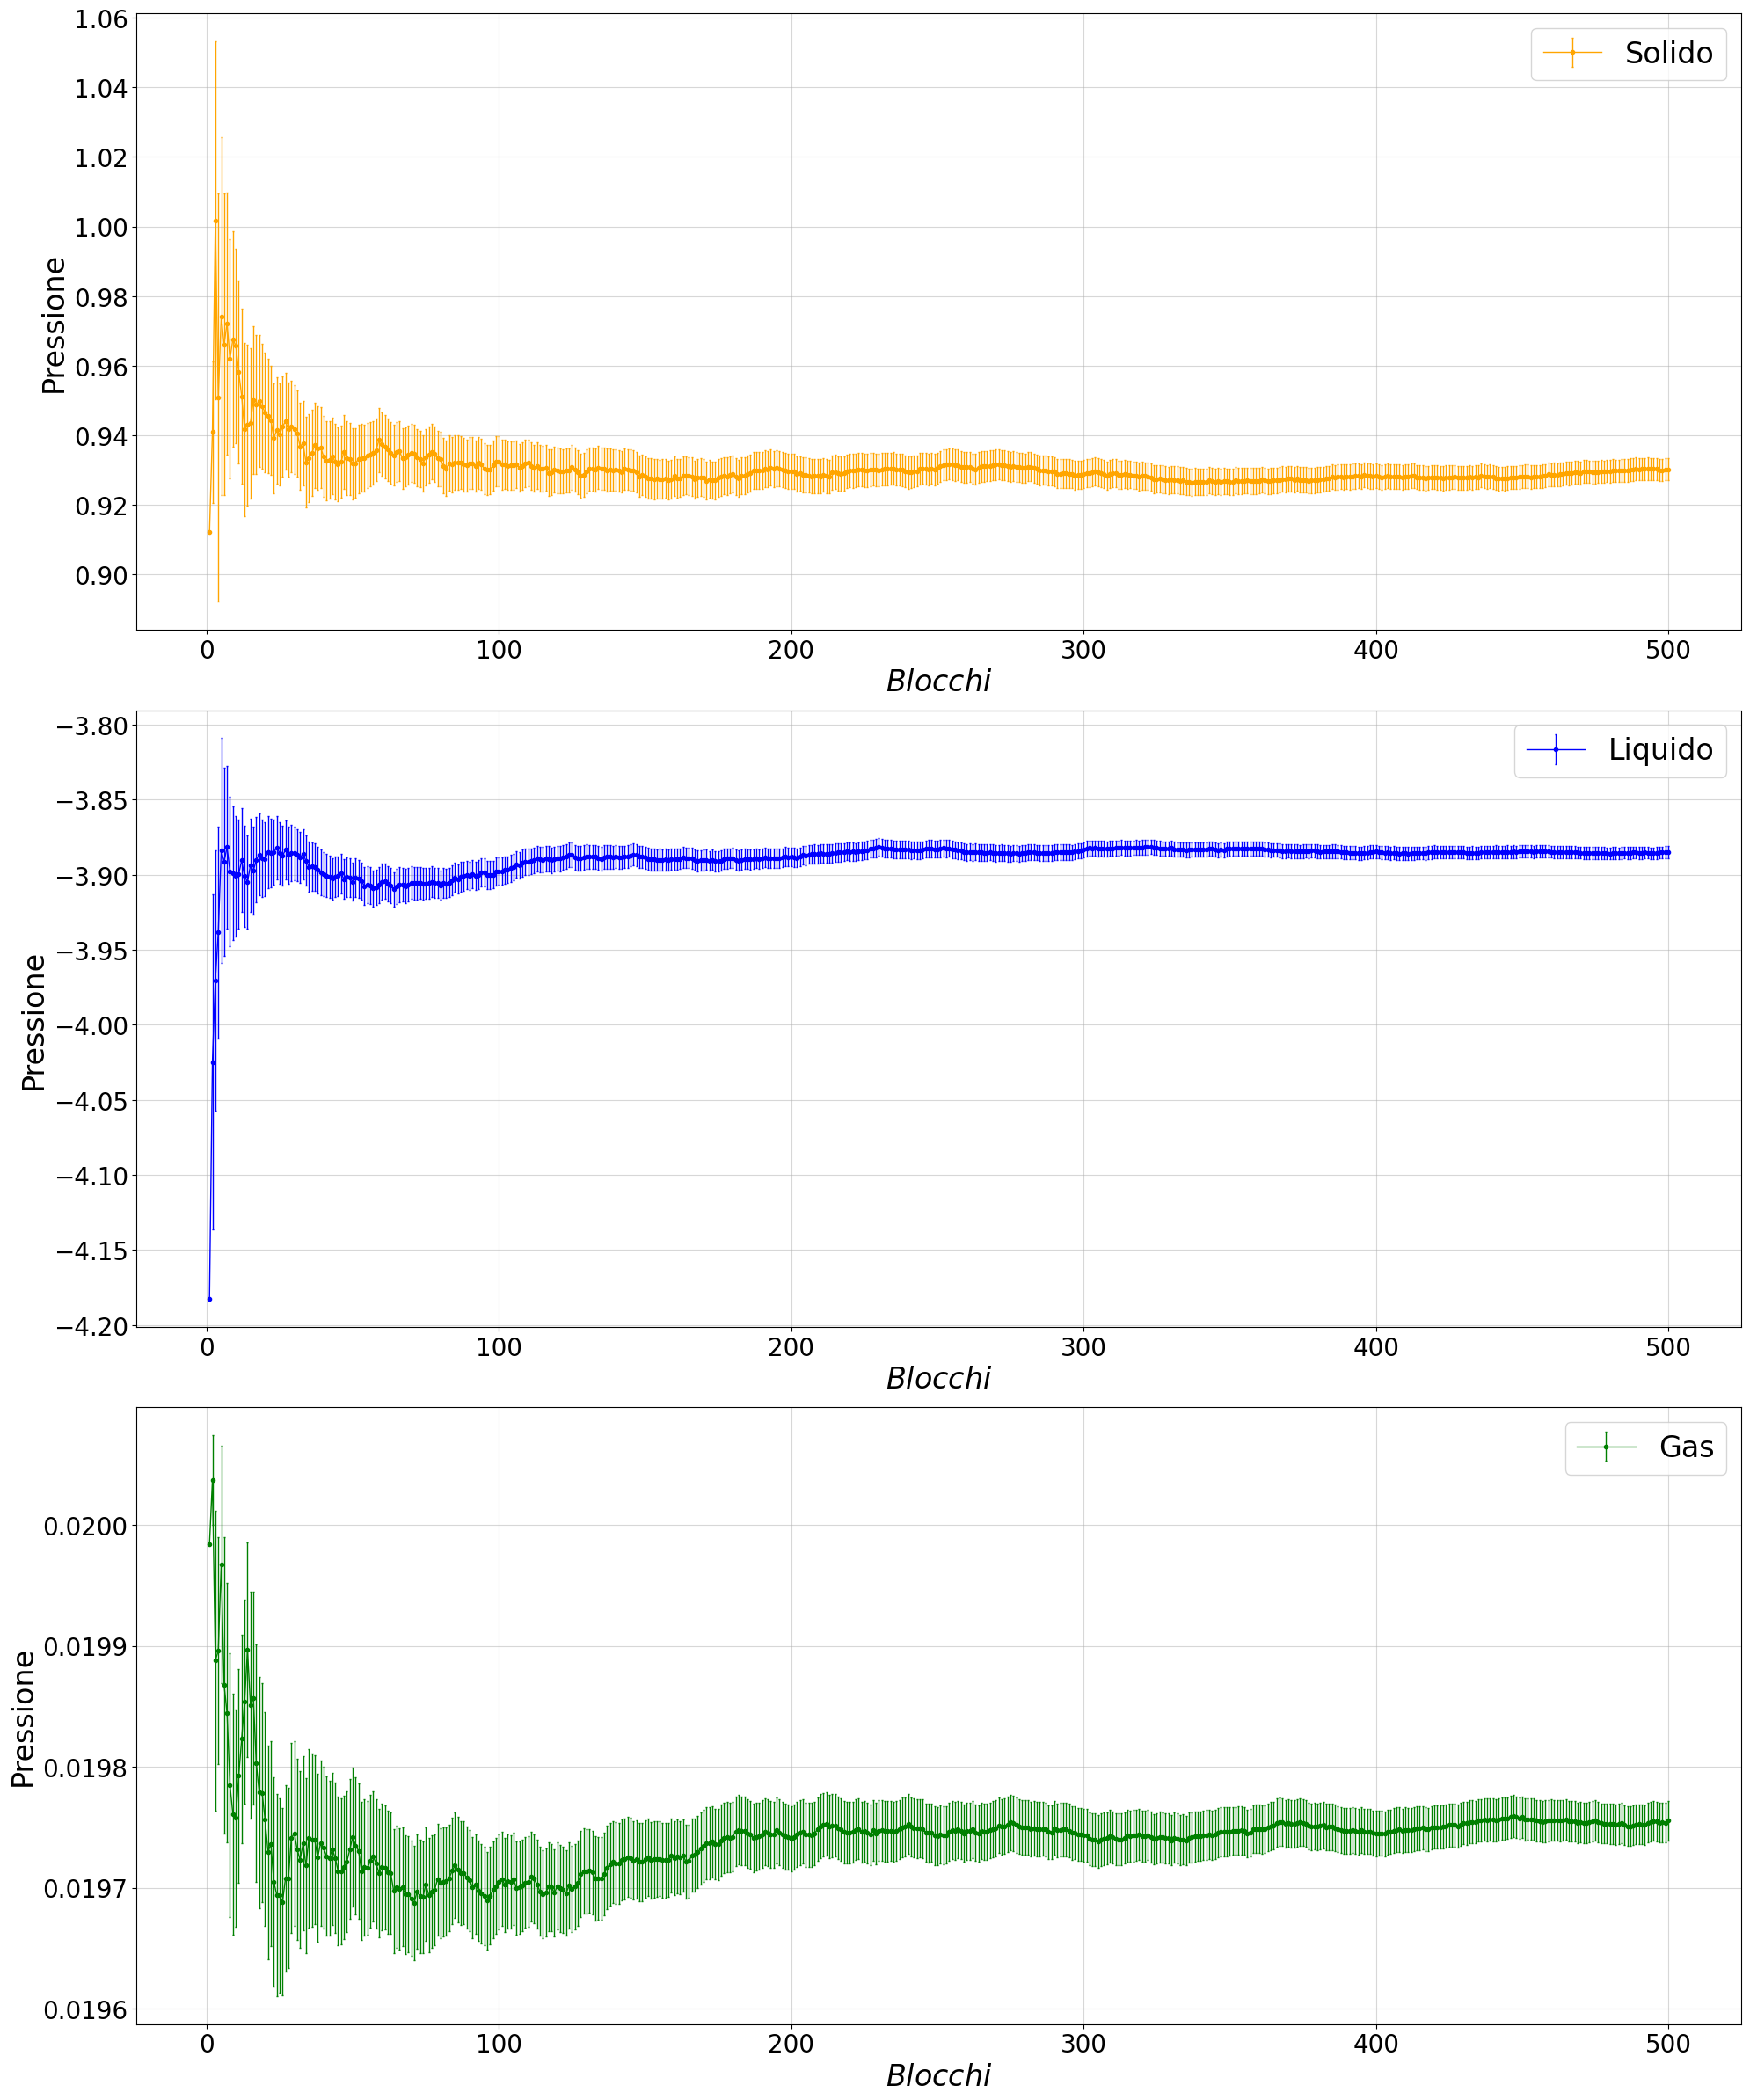

In [4]:
df_solid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/FINAL/pressure.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_P', 'P_AVE', 'ERROR'])
df_liquid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/FINAL/pressure.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_P', 'P_AVE', 'ERROR'])
df_gas = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/FINAL/pressure.dat", delim_whitespace=True, skiprows=1, names=['BLOCK', 'ACTUAL_P', 'P_AVE', 'ERROR'])

x = np.arange(1, 501, 1)

def plotting(name, abbreviation, phase, color, number, df):
    plt.subplot(3, 1, number)
    plt.errorbar(x, df[abbreviation + '_AVE'], yerr=df['ERROR'], fmt='o-', label=phase, color=color, markersize=3, linewidth=1, capsize=0.8)
    plt.xlabel('$Blocchi$', fontsize=24)
    plt.ylabel(name, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=24)

plt.figure(figsize=(20,24))

plotting('Pressione', 'P', 'Solido', 'orange', 1, df_solid)
plotting('Pressione', 'P', 'Liquido', 'blue', 2, df_liquid)
plotting('Pressione', 'P', 'Gas', 'green', 3, df_gas)

plt.tight_layout()
plt.show()

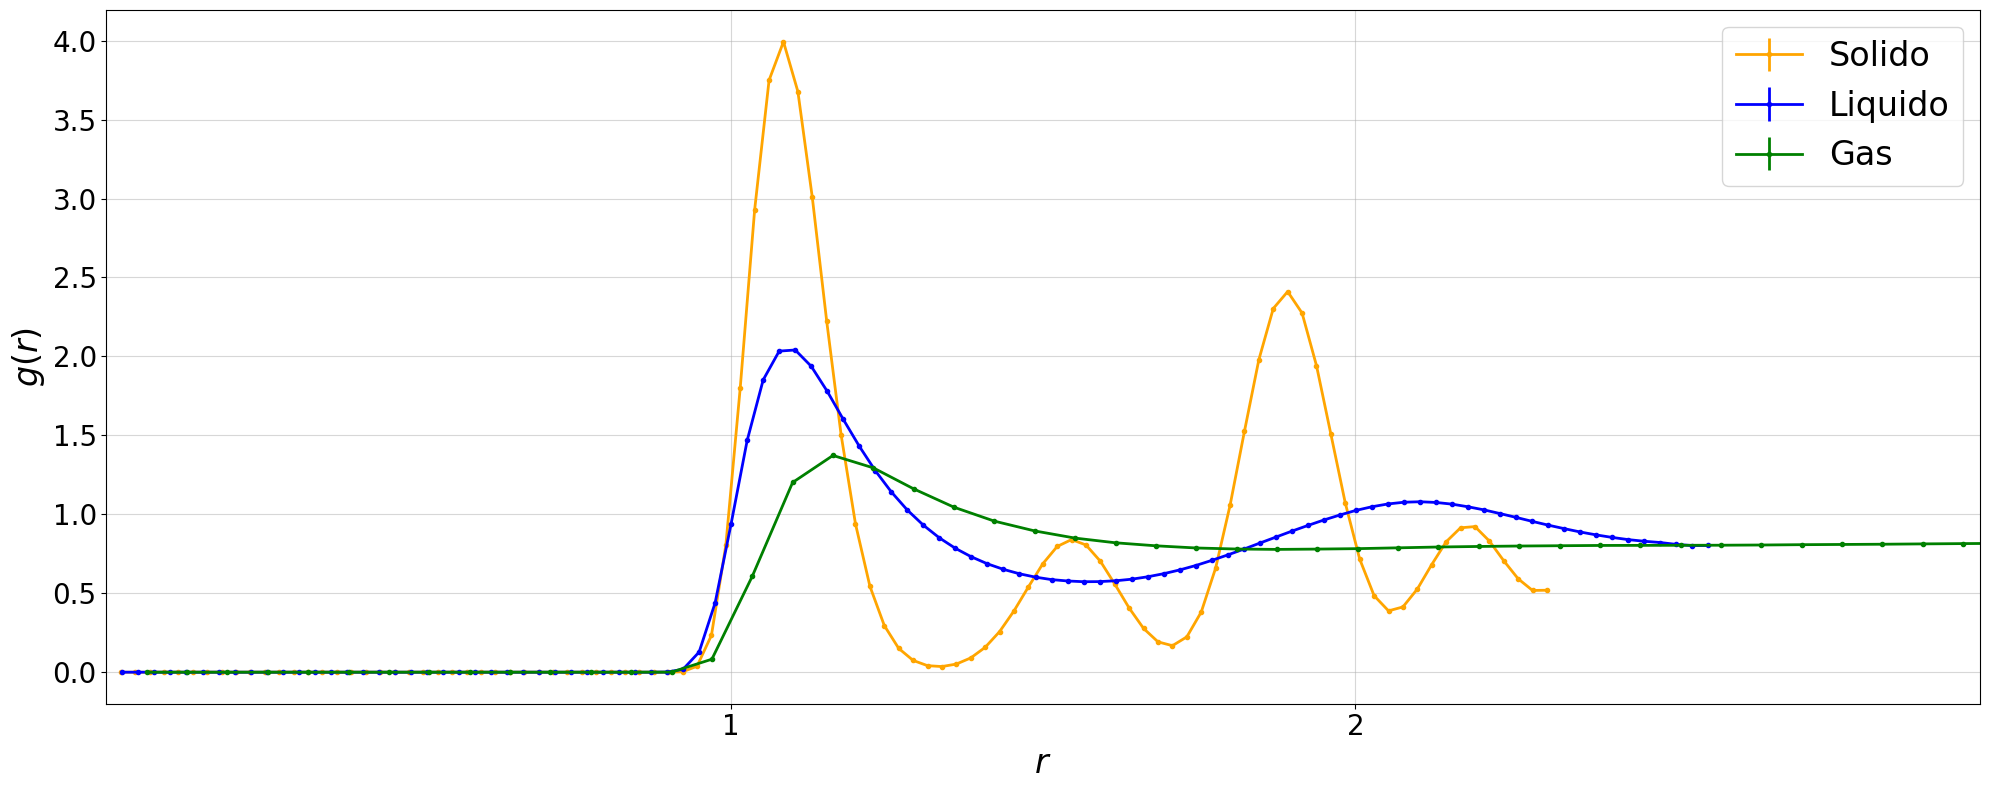

In [19]:
from matplotlib.ticker import MaxNLocator

df_solid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_liquid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_gas = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])

def plotting(name, abbreviation, phase, color, number, df):
    plt.errorbar(df['DISTANCE'], df['AVE_' + abbreviation], yerr=df['ERROR'], label=phase, color=color, linewidth=2, markersize=3, marker='o')
    plt.xlabel('$r$', fontsize=24)
    plt.ylabel(name, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=24)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

plt.figure(figsize=(20,8))

plotting('$g(r)$', 'GOFR', 'Solido', 'orange', 1, df_solid)
plotting('$g(r)$', 'GOFR', 'Liquido', 'blue', 2, df_liquid)
plotting('$g(r)$', 'GOFR', 'Gas', 'green', 3, df_gas)

plt.xlim(0,3)
plt.tight_layout()
plt.show()

La struttura della funzione di correlazione radiale $g(r)$ è coerente con il potenziale di Lennard-Jones. Non Si presentano particelle a distanze inferiori alla regione dove l'hard core repulsivo del potenziale diverge. Al contrario, intorno al minimo del potenziale, tutte e tre le fasi mostrano una struttura a "guscio", più o meno definito. Sia la fase liquida che quella solida presentano ulteriori gusci a raggi maggiori, più definiti per quella solida, il che sottolinea una struttura cristallina più ordinata.
Di seguito è riportata la differenza della $g(r)$ tra la simulazione Monte Carlo e la Molecular Dynamics, si può affermare che siano compatibili tra loro e che il nostro codice simuli bene un sistema reale.

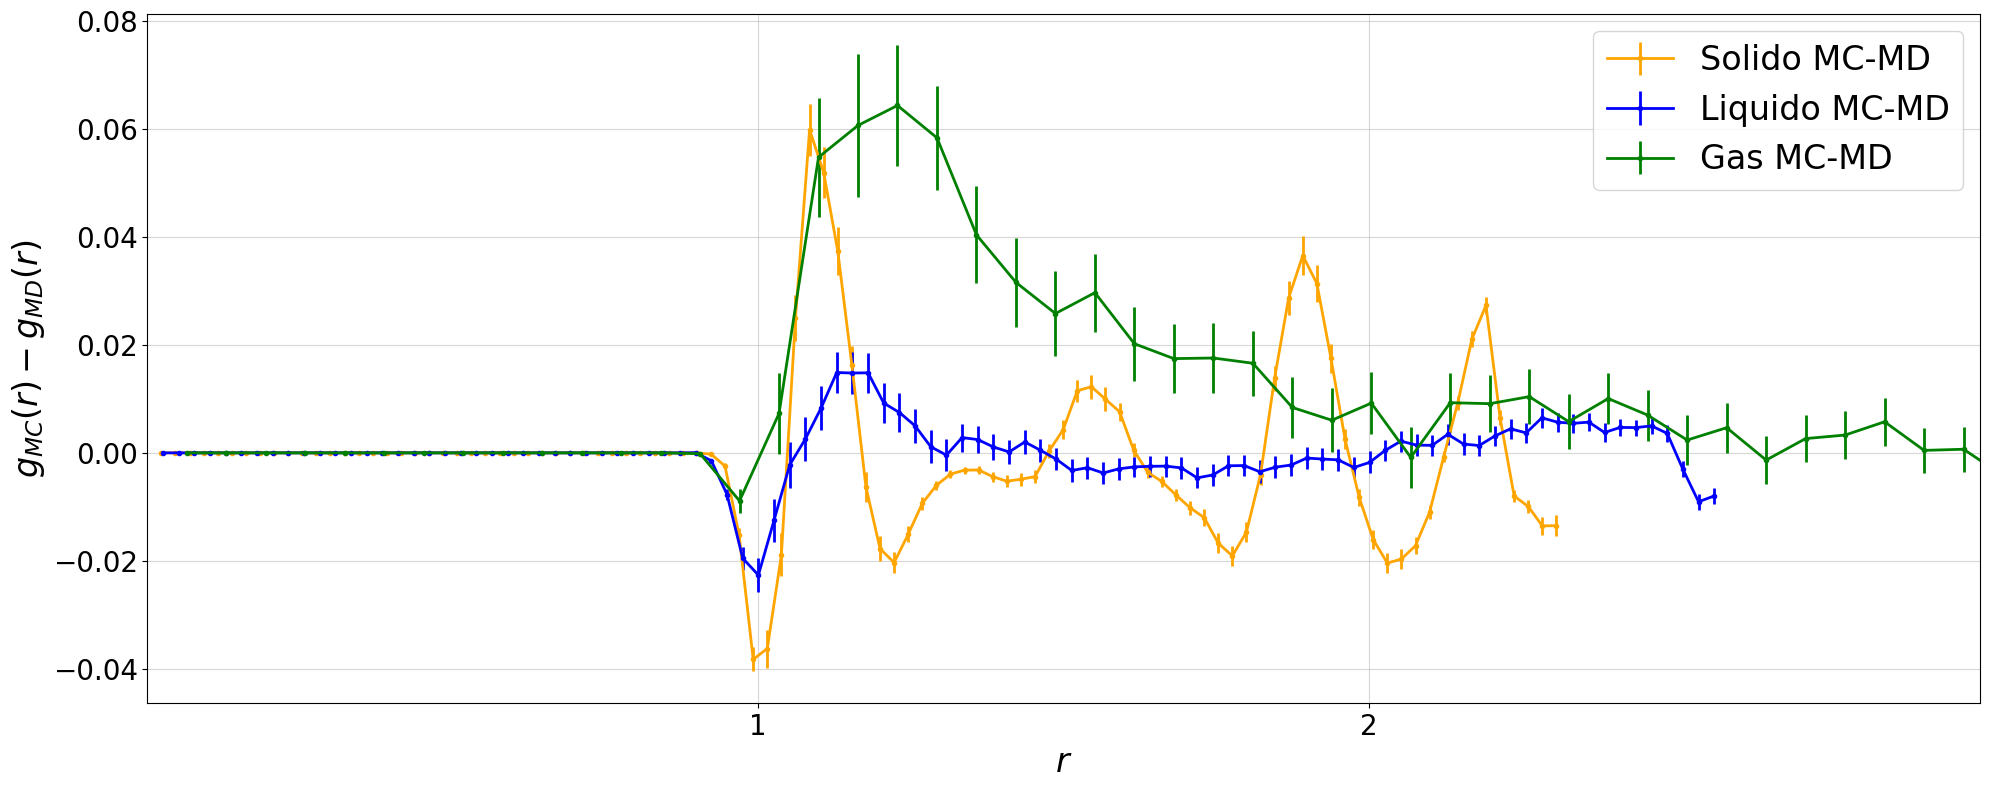

In [18]:
df_solid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_liquid = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_gas = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/FINAL/gofr.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_solid_MD = pd.read_csv("./NSL_SIMULATOR/OUTPUT/SOLID/FINAL/gofr_MD.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_liquid_MD = pd.read_csv("./NSL_SIMULATOR/OUTPUT/LIQUID/FINAL/gofr_MD.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])
df_gas_MD = pd.read_csv("./NSL_SIMULATOR/OUTPUT/GAS/FINAL/gofr_MD.dat", delim_whitespace=True, skiprows=1, names=['DISTANCE', 'AVE_GOFR', 'ERROR'])

def plotting(name, abbreviation, phase, color, number, df, df_2):
    plt.errorbar(df['DISTANCE'], df['AVE_' + abbreviation]-df_2['AVE_' + abbreviation], yerr=df['ERROR']+df_2['ERROR'], label=phase + ' MC-MD', color=color, linewidth=2, markersize=3, marker='o')
    plt.xlabel('$r$', fontsize=24)
    plt.ylabel(name, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=24)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

plt.figure(figsize=(20,8))

plotting('$g_{MC}(r)-g_{MD}(r)$', 'GOFR', 'Solido', 'orange', 1, df_solid, df_solid_MD)
plotting('$g_{MC}(r)-g_{MD}(r)$', 'GOFR', 'Liquido', 'blue', 2, df_liquid, df_liquid_MD)
plotting('$g_{MC}(r)-g_{MD}(r)$', 'GOFR', 'Gas', 'green', 3, df_gas, df_gas_MD)

plt.xlim(0,3)
plt.tight_layout()
plt.show()